In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')



print("--- 1. Loading and Preparing Data ---")
try:
    df = pd.read_csv("/content/final_master_dataset.csv")
except FileNotFoundError:
    print("Error: 'final_master_dataset.csv' not found. Please ensure the file is in the correct directory.")
    exit()

df.fillna(0, inplace=True)


df.sort_values(by=['player_id', 'season_name'], inplace=True)

print("Data loaded and sorted successfully.")
print(f"Dataset shape: {df.shape}")


print("\n--- 2. Milestone 4: Training Multivariate LSTM Model ---")
lstm_features = [
    'goals', 'assists', 'shots', 'total_xG', 'matches_played',
    'age_clean', 'total_days_missed', 'injury_count', 'average_sentiment',
    'market_value_eur'
]
target_col = 'market_value_eur'
df_lstm = df[['player_id'] + lstm_features].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm[lstm_features] = scaler.fit_transform(df_lstm[lstm_features])


def create_sequences(data, features, n_steps):

    X, y, player_ids_for_y = [], [], []

    target_idx = features.index(target_col)

    for player_id, group in data.groupby('player_id'):
        player_data = group[features].values
        if len(player_data) > n_steps:
            for i in range(len(player_data) - n_steps):
                X.append(player_data[i:(i + n_steps)])
                y.append(player_data[i + n_steps, target_idx])
                player_ids_for_y.append(player_id)

    return np.array(X), np.array(y), player_ids_for_y


n_steps = 2
X_seq, y_seq, _ = create_sequences(df_lstm, lstm_features, n_steps)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print(f"Created {len(X_seq)} sequences with {n_steps} time steps each.")
print(f"Shape of LSTM training data (X_train_seq): {X_train_seq.shape}")


lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1) # Output layer for predicting a single value
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()


print("\nTraining LSTM model...")
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)
print("LSTM model training complete.")


print("Generating predictions from LSTM to use as a feature...")
lstm_predictions_scaled = lstm_model.predict(X_seq)




print("\n--- 3. Milestone 5: Integrating LSTM with XGBoost ---")


flat_data_indices = []
for player_id, group in df.groupby('player_id'):
    if len(group) > n_steps:
        flat_data_indices.extend(group.index[n_steps-1:-1])


df_ensemble = df.loc[flat_data_indices].copy()


if len(df_ensemble) == len(lstm_predictions_scaled):
    df_ensemble['lstm_prediction_scaled'] = lstm_predictions_scaled
    print("Successfully added LSTM predictions as a new feature.")
else:
    print(f"Error: Mismatch in lengths. Ensemble df: {len(df_ensemble)}, LSTM preds: {len(lstm_predictions_scaled)}")
    exit()

df_ensemble[target_col] = df.loc[df_ensemble.index + 1, target_col].values


df_ensemble = pd.get_dummies(df_ensemble, columns=['age_category', 'simple_position'], drop_first=True)


X_ensemble = df_ensemble.drop(['player_id', 'player_name', 'season_name', 'market_value_eur'], axis=1)
y_ensemble = df_ensemble['market_value_eur']


for col in X_ensemble.columns:
    if X_ensemble[col].dtype == 'bool':
        X_ensemble[col] = X_ensemble[col].astype(int)


X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(X_ensemble, y_ensemble, test_size=0.2, random_state=42)

print(f"Shape of integrated training data: {X_train_ens.shape}")


xgb_ensemble = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=1000,
                                learning_rate=0.05,
                                max_depth=6,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                random_state=42,
                                n_jobs=-1)

print("\nTraining final XGBoost ensemble model...")
xgb_ensemble.fit(X_train_ens, y_train_ens,
                 eval_set=[(X_test_ens, y_test_ens)],
                 eval_metric='rmse',
                 early_stopping_rounds=50,
                 verbose=False)
print("Ensemble model training complete.")




print("\n--- 4. Final Ensemble Model Performance Evaluation ---")
y_pred_ens = xgb_ensemble.predict(X_test_ens)

rmse = np.sqrt(mean_squared_error(y_test_ens, y_pred_ens))
mae = mean_absolute_error(y_test_ens, y_pred_ens)
r2 = r2_score(y_test_ens, y_pred_ens)

print(f"Root Mean Squared Error (RMSE): €{rmse:,.2f}")
print(f"Mean Absolute Error (MAE):      €{mae:,.2f}")
print(f"R-squared (R²):                 {r2:.4f}")
print("----------------------------------------------------")
print("\nProcess finished successfully.")


--- 1. Loading and Preparing Data ---
Data loaded and sorted successfully.
Dataset shape: (907, 34)

--- 2. Milestone 4: Training Multivariate LSTM Model ---
Created 241 sequences with 2 time steps each.
Shape of LSTM training data (X_train_seq): (192, 2, 10)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,451 (126.76 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0686 - val_loss: 0.0355
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0596 - val_loss: 0.0316
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0449 - val_loss: 0.0316
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0434 - val_loss: 0.0272
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0423 - val_loss: 0.0221
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0271 - val_loss: 0.0179
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0250 - val_loss: 0.0139
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0182 - val_loss: 0.0096
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0169 - val_loss: 0.0059
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0078 - val_loss: 0.0055
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.

TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

Preparing data and performing feature engineering...
Saved feature correlation heatmap to 'model_evaluation/feature_correlation_heatmap.png'

--- STAGE 1: Training the Base LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- STAGE 2: Generating LSTM Predictions as a Feature ---

--- STAGE 3: Training the Meta XGBoost Model ---
Created 108 samples for the stacked model.
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 1000}

Evaluating stacked model performance...

Stacked Model Evaluation Complete.
Root Mean Squared Error (RMSE): €11,714,687.51
Mean Absolute Percentage Error (MAPE): 28.48%
Accuracy (predictions within 20% of actual): 40.91%

Saved feature importance plot to 'model_evaluation/stacked_model_feature_importance.png'


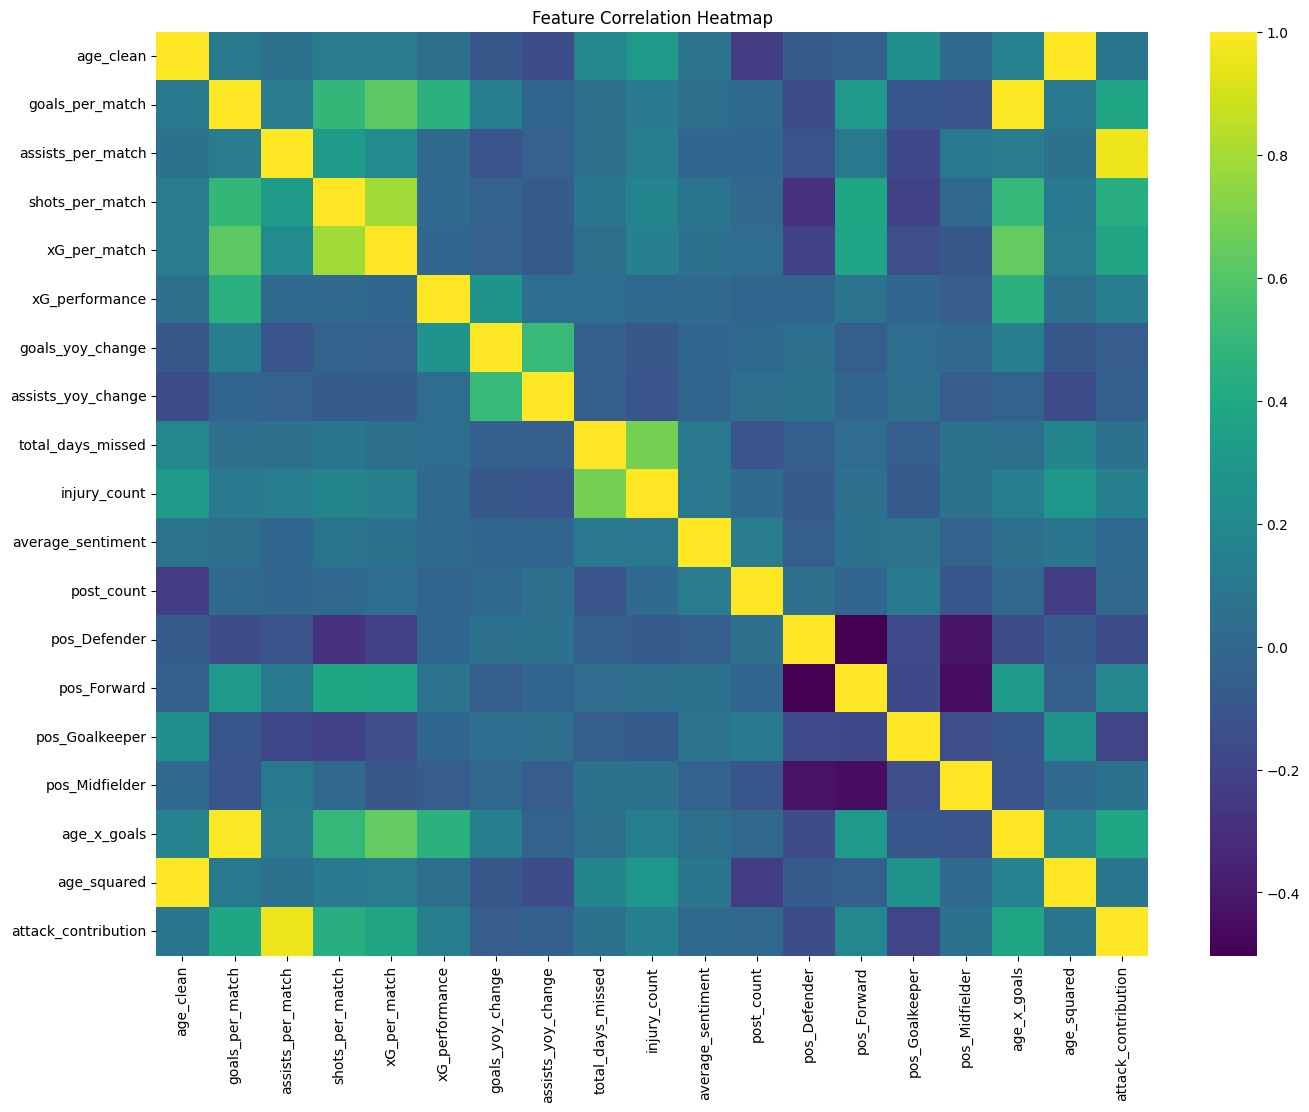

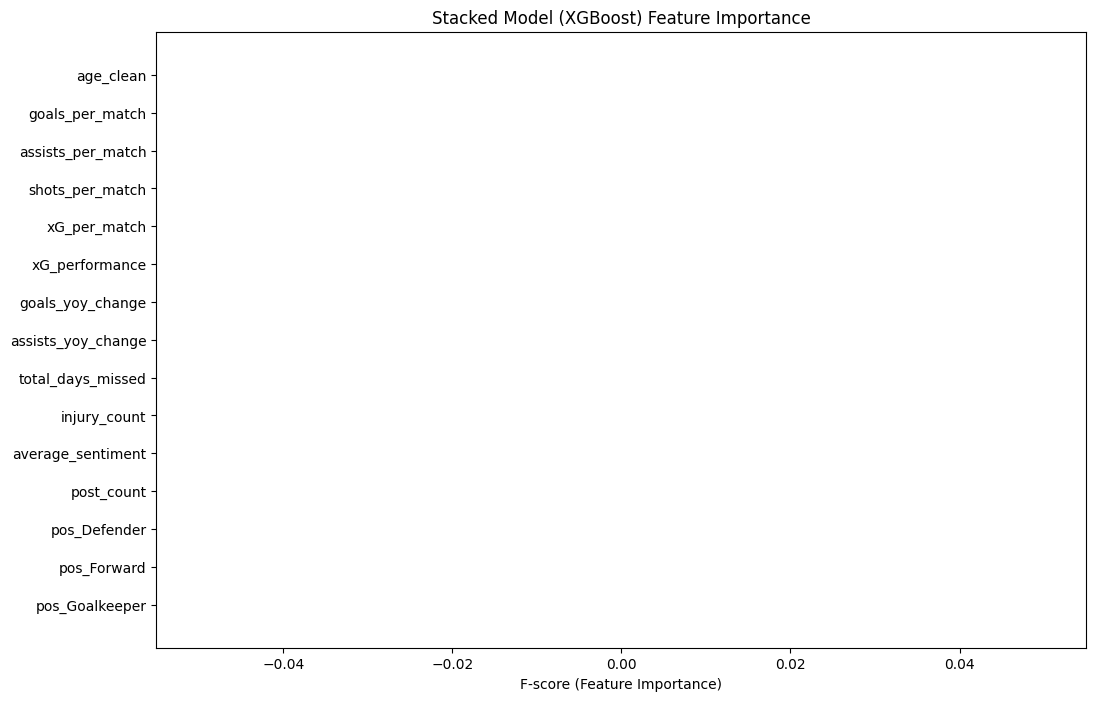


Saving all necessary components for the Streamlit app...
Saved: Final XGBoost model ('stacked_xgboost_model.pkl')
Saved: Base LSTM model ('lstm_model.keras')
Saved: LSTM feature scaler ('lstm_feature_scaler.pkl')
Saved: XGBoost feature scaler ('xgb_feature_scaler.pkl')

All components saved successfully!


In [1]:
# better results using this model


import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')


def create_sequences(data, feature_cols, target_col, sequence_length=3):
    X, y, player_ids, season_names = [], [], [], []
    for player_id, group in data.groupby('player_id'):
        player_seasons_features = group.sort_values('season_name')[feature_cols].values
        player_seasons_target = group.sort_values('season_name')[target_col].values

        if len(player_seasons_features) > sequence_length:
            for i in range(len(player_seasons_features) - sequence_length):
                sequence = player_seasons_features[i:i + sequence_length]
                target = player_seasons_target[i + sequence_length]
                X.append(sequence)
                y.append(target)
                player_ids.append(player_id)
                season_names.append(group.sort_values('season_name').iloc[i + sequence_length]['season_name'])

    return np.array(X), np.array(y), player_ids, season_names

def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=100, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(units=50),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(12, 8))
    importance = model.get_booster().get_score(importance_type='weight')
    used_features = {f: importance.get(f, 0.) for f in feature_names}
    sorted_features = sorted(used_features.items(), key=lambda x: x[1], reverse=True)
    features_to_plot = [item[0] for item in sorted_features[:15]]
    scores_to_plot = [item[1] for item in sorted_features[:15]]
    plt.barh(features_to_plot, scores_to_plot)
    plt.gca().invert_yaxis()
    plt.title('Stacked Model (XGBoost) Feature Importance')
    plt.xlabel('F-score (Feature Importance)')
    output_folder = "model_evaluation"
    os.makedirs(output_folder, exist_ok=True)
    plot_path = os.path.join(output_folder, "stacked_model_feature_importance.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"\nSaved feature importance plot to '{plot_path}'")
    plt.show()

def plot_correlation_heatmap(df, feature_cols):
    plt.figure(figsize=(16, 12))
    correlation_matrix = df[feature_cols].corr()
    sns.heatmap(correlation_matrix, cmap='viridis', annot=False) # Annot is false for readability with many features
    plt.title('Feature Correlation Heatmap')

    output_folder = "model_evaluation"
    os.makedirs(output_folder, exist_ok=True)
    plot_path = os.path.join(output_folder, "feature_correlation_heatmap.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"Saved feature correlation heatmap to '{plot_path}'")


if __name__ == "__main__":
    try:
        df = pd.read_csv("/content/final_master_dataset.csv")
    except FileNotFoundError:
        print("Error: 'final_master_dataset.csv' not found.")
        exit()

    print("Preparing data and performing feature engineering...")
    feature_columns = [
        'age_clean', 'goals_per_match', 'assists_per_match', 'shots_per_match',
        'xG_per_match', 'xG_performance', 'goals_yoy_change', 'assists_yoy_change',
        'total_days_missed', 'injury_count', 'average_sentiment', 'post_count',
        'pos_Defender', 'pos_Forward', 'pos_Goalkeeper', 'pos_Midfielder'
    ]
    target_column = 'market_value_eur'
    df_model = df[['player_id', 'season_name'] + feature_columns + [target_column]].copy().dropna()
    df_model['age_x_goals'] = df_model['age_clean'] * df_model['goals_per_match']
    df_model['age_squared'] = df_model['age_clean']**2
    df_model['attack_contribution'] = df_model['goals_per_match'] + df_model['assists_per_match']

    engineered_features = ['age_x_goals', 'age_squared', 'attack_contribution']
    lstm_feature_columns = feature_columns + engineered_features

    plot_correlation_heatmap(df_model, lstm_feature_columns)

    print("\n--- STAGE 1: Training the Base LSTM Model ---")

    feature_scaler_lstm = MinMaxScaler()
    df_lstm = df_model.copy()
    df_lstm[lstm_feature_columns] = feature_scaler_lstm.fit_transform(df_lstm[lstm_feature_columns])
    df_lstm[target_column] = np.log1p(df_lstm[target_column])

    X_seq, y_seq, _, _ = create_sequences(df_lstm, lstm_feature_columns, target_column)

    if len(X_seq) == 0:
        print("Not enough data to create sequences for LSTM. Exiting.")
        exit()

    X_train_lstm, _, y_train_lstm, _ = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

    lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)

    print("\n--- STAGE 2: Generating LSTM Predictions as a Feature ---")

    _, _, pred_player_ids, pred_season_names = create_sequences(df_lstm, lstm_feature_columns, target_column)
    lstm_predictions_log = lstm_model.predict(X_seq, verbose=0)

    df_predictions = pd.DataFrame({
        'player_id': pred_player_ids,
        'season_name': pred_season_names,
        'lstm_prediction': lstm_predictions_log.flatten()
    })

    df_model = pd.merge(df_model, df_predictions, on=['player_id', 'season_name'], how='left')

    print("\n--- STAGE 3: Training the Meta XGBoost Model ---")

    df_xgb = df_model.copy()
    df_xgb[target_column] = np.log1p(df_xgb[target_column])

    final_feature_columns = lstm_feature_columns + ['lstm_prediction']

    df_xgb.dropna(subset=['lstm_prediction'], inplace=True)
    df_xgb = df_xgb.sort_values(['player_id', 'season_name'])
    df_xgb['next_season_value'] = df_xgb.groupby('player_id')[target_column].shift(-1)
    df_xgb.dropna(subset=['next_season_value'], inplace=True)

    X = df_xgb[final_feature_columns]
    y = df_xgb['next_season_value']

    print(f"Created {len(X)} samples for the stacked model.")

    feature_scaler_xgb = MinMaxScaler()
    X_scaled = feature_scaler_xgb.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    #0.05,0.1
    param_grid = {'max_depth': [5, 7], 'learning_rate': [0.5, 1], 'n_estimators': [500, 1000]}
    xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters found: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    print("\nEvaluating stacked model performance...")
    predictions_log = best_model.predict(X_test)
    predictions_euros = np.expm1(predictions_log)
    y_test_euros = np.expm1(y_test)
    predictions_euros[predictions_euros < 0] = 0

    rmse = np.sqrt(np.mean((predictions_euros - y_test_euros)**2))
    mape = np.mean(np.abs((y_test_euros - predictions_euros) / (y_test_euros + 1e-8))) * 100
    accuracy_within_20_percent = (np.sum(np.abs(predictions_euros - y_test_euros) <= 0.20 * y_test_euros) / len(y_test_euros)) * 100

    print("\n" + "="*50)
    print(f"Stacked Model Evaluation Complete.")
    print(f"Root Mean Squared Error (RMSE): €{rmse:,.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy (predictions within 20% of actual): {accuracy_within_20_percent:.2f}%")
    print("="*50)


    plot_feature_importance(best_model, list(X.columns))

    print("\n" + "="*50)
    print("Saving all necessary components for the Streamlit app...")


    with open('stacked_xgboost_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("Saved: Final XGBoost model ('stacked_xgboost_model.pkl')")

    lstm_model.save('lstm_model.keras')
    print("Saved: Base LSTM model ('lstm_model.keras')")

    with open('lstm_feature_scaler.pkl', 'wb') as f:
        pickle.dump(feature_scaler_lstm, f)
    print("Saved: LSTM feature scaler ('lstm_feature_scaler.pkl')")


    with open('xgb_feature_scaler.pkl', 'wb') as f:
        pickle.dump(feature_scaler_xgb, f)
    print("Saved: XGBoost feature scaler ('xgb_feature_scaler.pkl')")

    print("\nAll components saved successfully!")
    print("="*50)

In [ ]:
# basic lstm

Preparing data for XGBoost model...
Created 467 samples for training.

Starting XGBoost model training...

Evaluating model performance...
Model Evaluation RMSE: €11,965,276.76

Saved feature importance plot to 'model_evaluation/xgboost_feature_importance.png'


<Figure size 1200x800 with 0 Axes>

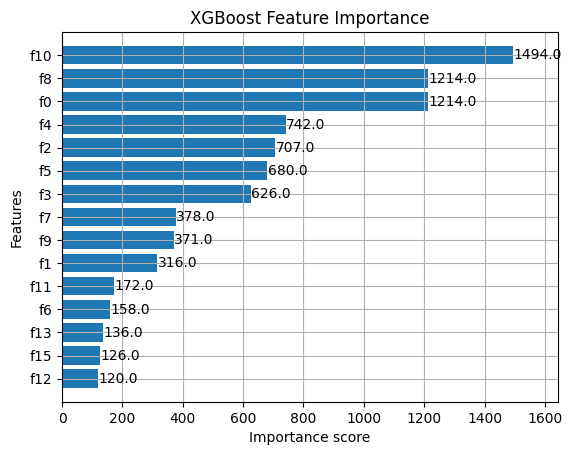


Saving components for the Streamlit app...
Saved: Simple XGBoost model ('xgb_simple_model.pkl')
Saved: Simple XGBoost scaler ('xgb_simple_scaler.pkl')

All components saved successfully!


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import pickle

def prepare_data_for_xgboost(data, feature_cols, target_col):

    X, y = [], []
    data = data.sort_values(['player_id', 'season_name'])

    data['next_season_value'] = data.groupby('player_id')[target_col].shift(-1)

    data.dropna(subset=['next_season_value'], inplace=True)

    X = data[feature_cols]
    y = data['next_season_value']

    return X, y

def plot_feature_importance(model, feature_names, output_folder="model_evaluation"):
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(model, height=0.8, max_num_features=15, title="XGBoost Feature Importance")

    os.makedirs(output_folder, exist_ok=True)
    plot_path = os.path.join(output_folder, "xgboost_feature_importance.png")
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"\nSaved feature importance plot to '{plot_path}'")
    plt.show()

if __name__ == "__main__":
    try:
        df = pd.read_csv("/content/final_master_dataset.csv")
    except FileNotFoundError:
        print("Error: 'final_master_dataset.csv' not found. Make sure it's uploaded to your Colab session.")
        exit()

    print("Preparing data for XGBoost model...")
    feature_columns = [
        'age_clean', 'goals_per_match', 'assists_per_match', 'shots_per_match',
        'xG_per_match', 'xG_performance', 'goals_yoy_change', 'assists_yoy_change',
        'total_days_missed', 'injury_count', 'average_sentiment', 'post_count',
        'pos_Defender', 'pos_Forward', 'pos_Goalkeeper', 'pos_Midfielder'
    ]
    target_column = 'market_value_eur'

    df_model = df[['player_id', 'season_name', 'player_name'] + feature_columns + [target_column]].copy()
    df_model.dropna(inplace=True)


    df_model[target_column] = np.log1p(df_model[target_column])
    X, y = prepare_data_for_xgboost(df_model, feature_columns, target_column)

    print(f"Created {len(X)} samples for training.")

    feature_scaler = MinMaxScaler()
    X_scaled = feature_scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    xgboost_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )

    print("\nStarting XGBoost model training...")
    xgboost_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


    print("\nEvaluating model performance...")
    predictions_log = xgboost_model.predict(X_test)
    predictions_euros = np.expm1(predictions_log)
    y_test_euros = np.expm1(y_test)
    rmse = np.sqrt(np.mean((predictions_euros - y_test_euros)**2))
    print(f"Model Evaluation RMSE: €{rmse:,.2f}")


    plot_feature_importance(xgboost_model, feature_columns)


    print("\n" + "="*50)
    print("Saving components for the Streamlit app...")


    with open('xgb_simple_model.pkl', 'wb') as f:
        pickle.dump(xgboost_model, f)
    print("Saved: Simple XGBoost model ('xgb_simple_model.pkl')")

    with open('xgb_simple_scaler.pkl', 'wb') as f:
        pickle.dump(feature_scaler, f)
    print("Saved: Simple XGBoost scaler ('xgb_simple_scaler.pkl')")

    print("\nAll components saved successfully!")
    print("="*50)


# New Section

# Streamlit app


In [3]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf


@st.cache_resource
def load_all_components():
    try:
        with open('stacked_xgboost_model.pkl', 'rb') as f:
            xgb_model = pickle.load(f)
        lstm_model = tf.keras.models.load_model('lstm_model.keras')
        with open('lstm_feature_scaler.pkl', 'rb') as f:
            lstm_scaler = pickle.load(f)
        with open('xgb_feature_scaler.pkl', 'rb') as f:
            xgb_scaler = pickle.load(f)
        return xgb_model, lstm_model, lstm_scaler, xgb_scaler
    except FileNotFoundError:
        return None, None, None, None



@st.cache_data
def load_player_data():
    try:
        df = pd.read_csv("/content/final_master_dataset.csv")
        player_season_counts = df['player_name'].value_counts()
        eligible_players = player_season_counts[player_season_counts >= 3].index.sort_values().tolist()
        return df, eligible_players
    except FileNotFoundError:
        return None, None



def make_stacked_prediction(player_data_df):
    feature_cols = [
        'age_clean', 'goals_per_match', 'assists_per_match', 'shots_per_match',
        'xG_per_match', 'xG_performance', 'goals_yoy_change', 'assists_yoy_change',
        'total_days_missed', 'injury_count', 'average_sentiment', 'post_count',
        'pos_Defender', 'pos_Forward', 'pos_Goalkeeper', 'pos_Midfielder'
    ]


    player_data_df = player_data_df.copy()


    player_data_df['age_x_goals'] = player_data_df['age_clean'] * player_data_df['goals_per_match']
    player_data_df['age_squared'] = player_data_df['age_clean']**2
    player_data_df['attack_contribution'] = player_data_df['goals_per_match'] + player_data_df['assists_per_match']


    all_feature_cols = feature_cols + ['age_x_goals', 'age_squared', 'attack_contribution']

    lstm_features_scaled = lstm_scaler.transform(player_data_df[all_feature_cols])
    sequence = np.array([lstm_features_scaled])
    lstm_prediction_log = lstm_model.predict(sequence, verbose=0)[0][0]

    xgb_input_data = player_data_df.iloc[-1][all_feature_cols].to_dict()
    xgb_input_data['lstm_prediction'] = lstm_prediction_log

    xgb_df = pd.DataFrame([xgb_input_data])

    final_feature_columns = all_feature_cols + ['lstm_prediction']
    xgb_features_for_scaling = xgb_df[final_feature_columns]

    xgb_features_scaled = xgb_scaler.transform(xgb_features_for_scaling)

    final_prediction_log = xgb_model.predict(xgb_features_scaled)[0]
    final_prediction_euros = np.expm1(final_prediction_log)

    return max(0, final_prediction_euros)




xgb_model, lstm_model, lstm_scaler, xgb_scaler = load_all_components()
player_df, eligible_players = load_player_data()

st.set_page_config(
    page_title="Player Market Value Predictor ⚽",
    page_icon="🧠",
    layout="wide"
)

st.title("⚽ Football Player Market Value Predictor")

if not all([xgb_model, lstm_model, player_df is not None]):
    st.error("One or more essential files (model or dataset) could not be found. Please ensure all files are uploaded to the Colab session.")
else:
    st.write("""
    Select a player from the dropdown menu to predict their market value for the upcoming season.
    The model uses the player's performance data from their last three available seasons.
    """)
    st.write("---")


    selected_player = st.selectbox(
        '**Select a Player to Analyze**',
        options=eligible_players,
        index=None, # No default selection
        placeholder="Search for a player..."
    )

    if selected_player:
        st.header(f"Analyzing: {selected_player}")

        player_data = player_df[player_df['player_name'] == selected_player].sort_values('season_name').tail(3)

        st.subheader("Historical Data Used for Prediction")
        st.write("Showing the last 3 seasons of performance data that will be fed into the model:")


        display_cols = [
            'season_name', 'age_clean', 'simple_position', 'goals', 'assists', 'matches_played',
            'total_xG', 'total_days_missed', 'injury_count'
        ]
        st.dataframe(player_data[display_cols], use_container_width=True, hide_index=True)


        if st.button(f"**Predict {selected_player}'s Next Season Value**", use_container_width=True):
            if len(player_data) < 3:
                st.error("This player does not have enough historical data (requires 3 seasons).")
            else:
                with st.spinner('Running the advanced prediction model... This may take a moment.'):
                    predicted_value = make_stacked_prediction(player_data)

                st.success(f"### Predicted Market Value for {selected_player}: **€{predicted_value:,.2f}**")
                st.balloons()



Writing app.py


In [ ]:
# TO RUN STREAMLIT APP USED NGROK

In [4]:

!streamlit run app.py &>/dev/null&

from pyngrok import ngrok
ngrok.kill()

NGROK_AUTH_TOKEN = "33nRw4m2snTo2CW50it7wUO0grP_5HPPZnNeLBuW6y4Jrd5vL"
if NGROK_AUTH_TOKEN:
  ngrok.set_auth_token(NGROK_AUTH_TOKEN)


public_url = ngrok.connect(8501)
print(f"Click the following link to view your app: {public_url}")

Click the following link to view your app: NgrokTunnel: "https://viscous-jaclyn-noncruciform.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
# run this code in the terminal after restarting


In [ ]:
#pip install streamlit pyngrok tensorflow xgboost scikit-learn